In [2]:
import datetime
import os
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from notebook_shared import utils

from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import Series

import seaborn as sns
sns.set()
matplotlib.style.use('seaborn-colorblind')

INPUT_FILE = "dataset"
FSIZE = "tiny"

df = pd.read_parquet(utils.get_dataset_path(INPUT_FILE, FSIZE))
sns.set(font_scale=1.4)

In [3]:
uuid_unique_count_df = df.groupby(['measure group', 'provider', 'region', 'driver_invocation'], observed=True)['uuid'].nunique().reset_index(name='Unique Container Id')

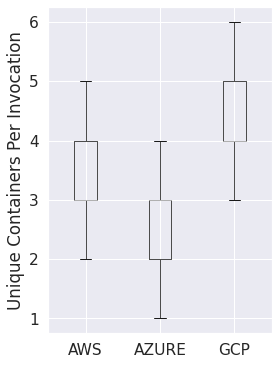

data 
          Unique Container Id                                             
                       count      mean       std  min  25%  50%  75%  max
provider                                                                 
AWS                  28927.0  3.239050  0.657055  1.0  3.0  3.0  4.0  5.0
AZURE                25935.0  2.522961  0.679154  1.0  2.0  3.0  3.0  4.0
GCP                  29006.0  4.177515  0.906849  1.0  4.0  4.0  5.0  6.0


In [4]:
fig, axes = plt.subplots(figsize=(4,6), ncols=1, nrows=1, frameon=False, sharex=True)

bxdf = uuid_unique_count_df[['provider', 'Unique Container Id']].groupby(['provider'], observed=True)
utils.boxplot(axes, bxdf, "Unique Containers Per Invocation", utils.tick_get_1st)
utils.plot(['provider_analysis_instances', 'pa_instances_unique_containers_per_run'], data=bxdf.describe())

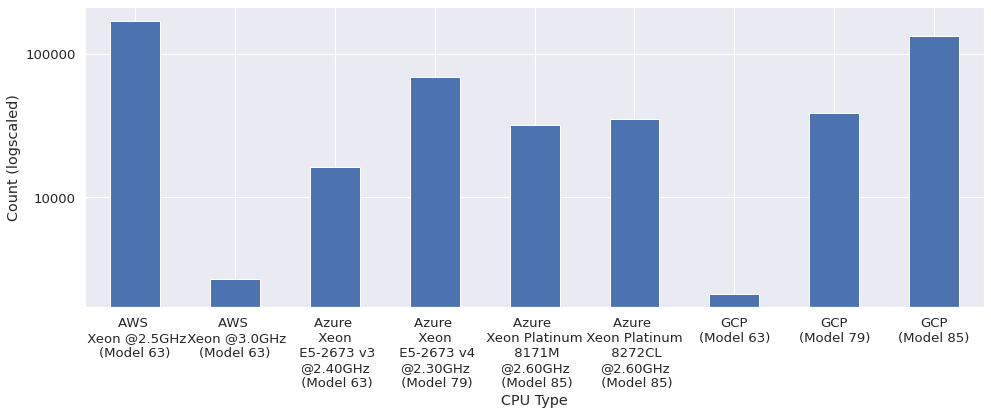

data 
                                                                       workload_invocation
provider cpuModel cpuType                                                                
AWS      63       Intel(R) Xeon(R) Processor @ 2.50GHz - Model 63                  170863
                  Intel(R) Xeon(R) Processor @ 3.00GHz - Model 63                    2703
AZURE    63       Intel(R) Xeon(R) CPU E5-2673 v3 @ 2.40GHz - Mod...                16145
         79       Intel(R) Xeon(R) CPU E5-2673 v4 @ 2.30GHz - Mod...                68510
         85       Intel(R) Xeon(R) Platinum 8171M CPU @ 2.60GHz -...                31893
                  Intel(R) Xeon(R) Platinum 8272CL CPU @ 2.60GHz ...                35414
GCP      63       unknown - Model 63                                                 2124
         79       unknown - Model 79                                                38765
         85       unknown - Model 85                                               133119


In [22]:
from matplotlib.ticker import ScalarFormatter
sns.set(font_scale=1.2)

cpudf = df[['provider', 'cpuModel', 'cpuType', 'workload_invocation']]
cpu_counts = cpudf.groupby(['provider', 'cpuModel','cpuType'], observed=True)

fig, axes = plt.subplots(figsize=(14,6))
cpu_counts.count().plot(ax=axes, kind='bar')

cpu_type_rewrite = {
    "(AWS, 63, Intel(R) Xeon(R) Processor @ 2.50GHz - Model 63)": "AWS \n Xeon @2.5GHz\n(Model 63)",
    "(AWS, 63, Intel(R) Xeon(R) Processor @ 3.00GHz - Model 63)" : "AWS \n Xeon @3.0GHz\n(Model 63)",
    "(AZURE, 63, Intel(R) Xeon(R) CPU E5-2673 v3 @ 2.40GHz - Model 63)" : "Azure \n Xeon \n E5-2673 v3\n@2.40GHz\n (Model 63)",
    "(AZURE, 79, Intel(R) Xeon(R) CPU E5-2673 v4 @ 2.30GHz - Model 79)" : "Azure \n Xeon \n E5-2673 v4\n@2.30GHz\n (Model 79)",
    "(AZURE, 85, Intel(R) Xeon(R) Platinum 8171M CPU @ 2.60GHz - Model 85)" : "Azure \n Xeon Platinum \n 8171M\n@2.60GHz\n (Model 85)",
    "(AZURE, 85, Intel(R) Xeon(R) Platinum 8272CL CPU @ 2.60GHz - Model 85)" : "Azure \n Xeon Platinum \n 8272CL\n@2.60GHz\n (Model 85)",
    "(GCP, 63, unknown - Model 63)" : "GCP\n(Model 63)",
    "(GCP, 79, unknown - Model 79)" : "GCP\n(Model 79)",
    "(GCP, 85, unknown - Model 85)" : "GCP\n(Model 85)",
}

labels = []
for tick in axes.get_xticklabels():
    if tick.get_text() in cpu_type_rewrite.keys():
        labels.append(cpu_type_rewrite[tick.get_text()])
    else:
        labels.append(tick.get_text())
    
axes.set_xlabel('CPU Type')      
axes.set_ylabel('Count (logscaled)')
axes.set_xticklabels(labels)
plt.setp(axes.get_xticklabels(), rotation=0)
axes.get_legend().remove()
axes.set_yscale('log')
axes.yaxis.set_major_formatter(ScalarFormatter())

fig.tight_layout()
utils.plot(['provider_analysis_instances', 'pa_instances_cputype'], data=cpu_counts.count())

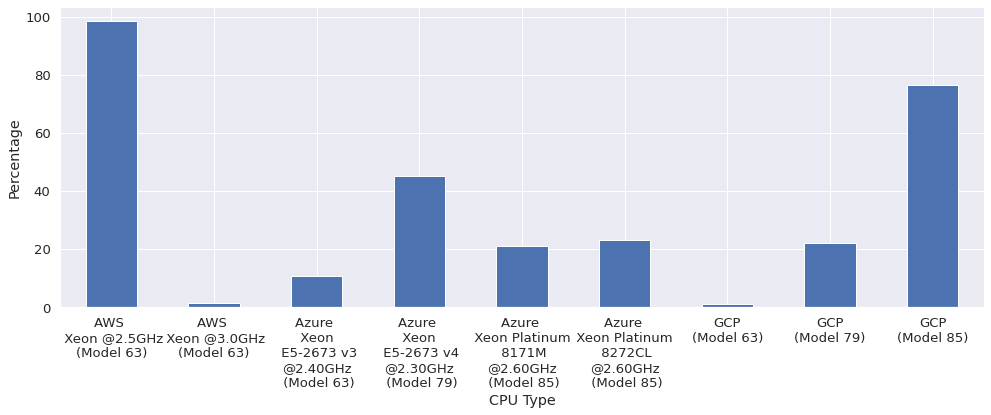

data 
                                                                       workload_invocation
provider cpuModel cpuType                                                                
AWS      63       Intel(R) Xeon(R) Processor @ 2.50GHz - Model 63               98.442667
                  Intel(R) Xeon(R) Processor @ 3.00GHz - Model 63                1.557333
AZURE    63       Intel(R) Xeon(R) CPU E5-2673 v3 @ 2.40GHz - Mod...            10.624367
         79       Intel(R) Xeon(R) CPU E5-2673 v4 @ 2.30GHz - Mod...            45.083639
         85       Intel(R) Xeon(R) Platinum 8171M CPU @ 2.60GHz -...            20.987484
                  Intel(R) Xeon(R) Platinum 8272CL CPU @ 2.60GHz ...            23.304510
GCP      63       unknown - Model 63                                             1.220634
         79       unknown - Model 79                                            22.277711
         85       unknown - Model 85                                            76.501655


In [23]:
from matplotlib.ticker import ScalarFormatter
sns.set(font_scale=1.2)

cpudf = df[['provider', 'cpuModel', 'cpuType', 'workload_invocation']]
cpu_counts = cpudf.groupby(['provider', 'cpuModel','cpuType'], observed=True)
cpu_counts_total = pd.DataFrame(cpu_counts.count().groupby('provider', group_keys=False).apply(lambda df: (df['workload_invocation'] / df['workload_invocation'].sum()) * 100) )

fig, axes = plt.subplots(figsize=(14,6))
# cpu_counts.count().plot(ax=axes, kind='bar')
cpu_counts_total.plot(ax=axes, kind='bar')

cpu_type_rewrite = {
    "(AWS, 63, Intel(R) Xeon(R) Processor @ 2.50GHz - Model 63)": "AWS \n Xeon @2.5GHz\n(Model 63)",
    "(AWS, 63, Intel(R) Xeon(R) Processor @ 3.00GHz - Model 63)" : "AWS \n Xeon @3.0GHz\n(Model 63)",
    "(AZURE, 63, Intel(R) Xeon(R) CPU E5-2673 v3 @ 2.40GHz - Model 63)" : "Azure \n Xeon \n E5-2673 v3\n@2.40GHz\n (Model 63)",
    "(AZURE, 79, Intel(R) Xeon(R) CPU E5-2673 v4 @ 2.30GHz - Model 79)" : "Azure \n Xeon \n E5-2673 v4\n@2.30GHz\n (Model 79)",
    "(AZURE, 85, Intel(R) Xeon(R) Platinum 8171M CPU @ 2.60GHz - Model 85)" : "Azure \n Xeon Platinum \n 8171M\n@2.60GHz\n (Model 85)",
    "(AZURE, 85, Intel(R) Xeon(R) Platinum 8272CL CPU @ 2.60GHz - Model 85)" : "Azure \n Xeon Platinum \n 8272CL\n@2.60GHz\n (Model 85)",
    "(GCP, 63, unknown - Model 63)" : "GCP\n(Model 63)",
    "(GCP, 79, unknown - Model 79)" : "GCP\n(Model 79)",
    "(GCP, 85, unknown - Model 85)" : "GCP\n(Model 85)",
}

labels = []
for tick in axes.get_xticklabels():
    if tick.get_text() in cpu_type_rewrite.keys():
        labels.append(cpu_type_rewrite[tick.get_text()])
    else:
        labels.append(tick.get_text())
    
axes.set_xlabel('CPU Type')      
axes.set_ylabel('Percentage')
axes.set_xticklabels(labels)
plt.setp(axes.get_xticklabels(), rotation=0)
axes.get_legend().remove()
# axes.set_yscale('log')
axes.yaxis.set_major_formatter(ScalarFormatter())

fig.tight_layout()
utils.plot(['provider_analysis_instances', 'pa_instances_cputype_percentage'], data=cpu_counts_total)

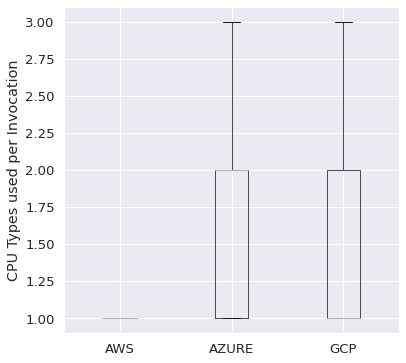

data 
          Unique CPU Types                                             
                    count      mean       std  min  25%  50%  75%  max
provider                                                              
AWS               28927.0  1.039306  0.194325  1.0  1.0  1.0  1.0  2.0
AZURE             25935.0  1.633854  0.607372  1.0  1.0  2.0  2.0  4.0
GCP               29006.0  1.402193  0.524590  1.0  1.0  1.0  2.0  3.0


In [17]:
cpu_count_df = df.groupby(['measure group', 'provider', 'region', 'driver_invocation'], observed=True)['cpuType'].nunique().reset_index(name='Unique CPU Types')

fig, axes = plt.subplots(figsize=(6,6))

bxdf = cpu_count_df.groupby(['provider'])
utils.boxplot(axes, bxdf, "CPU Types used per Invocation", utils.tick_get_1st)
utils.plot(['provider_analysis_instances', 'pa_instance_cpus_types_per_invocation'], data=bxdf.describe())

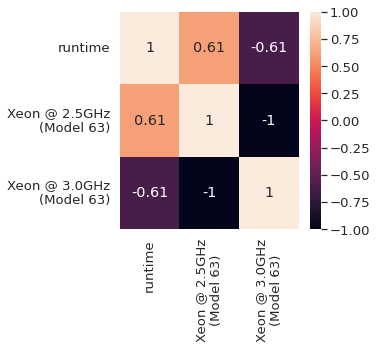

data 
                                                      runtime  \
runtime                                             1.000000   
cpuType_Intel(R) Xeon(R) Processor @ 2.50GHz - ...  0.612068   
cpuType_Intel(R) Xeon(R) Processor @ 3.00GHz - ... -0.612068   

                                                    cpuType_Intel(R) Xeon(R) Processor @ 2.50GHz - Model 63  \
runtime                                                                                      0.612068         
cpuType_Intel(R) Xeon(R) Processor @ 2.50GHz - ...                                           1.000000         
cpuType_Intel(R) Xeon(R) Processor @ 3.00GHz - ...                                          -1.000000         

                                                    cpuType_Intel(R) Xeon(R) Processor @ 3.00GHz - Model 63  
runtime                                                                                     -0.612068        
cpuType_Intel(R) Xeon(R) Processor @ 2.50GHz - ...                     

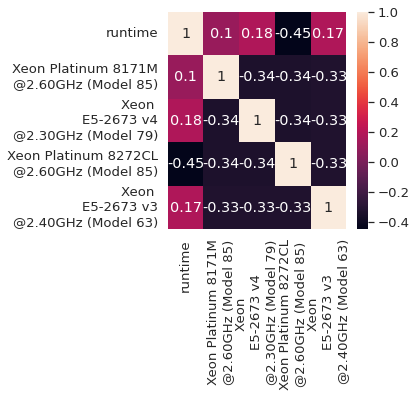

data 
                                                      runtime  \
runtime                                             1.000000   
cpuType_Intel(R) Xeon(R) Platinum 8171M CPU @ 2...  0.100607   
cpuType_Intel(R) Xeon(R) CPU E5-2673 v4 @ 2.30G...  0.178011   
cpuType_Intel(R) Xeon(R) Platinum 8272CL CPU @ ... -0.449808   
cpuType_Intel(R) Xeon(R) CPU E5-2673 v3 @ 2.40G...  0.174814   

                                                    cpuType_Intel(R) Xeon(R) Platinum 8171M CPU @ 2.60GHz - Model 85  \
runtime                                                                                      0.100607                  
cpuType_Intel(R) Xeon(R) Platinum 8171M CPU @ 2...                                           1.000000                  
cpuType_Intel(R) Xeon(R) CPU E5-2673 v4 @ 2.30G...                                          -0.340557                  
cpuType_Intel(R) Xeon(R) Platinum 8272CL CPU @ ...                                          -0.339848                  
cpuType_

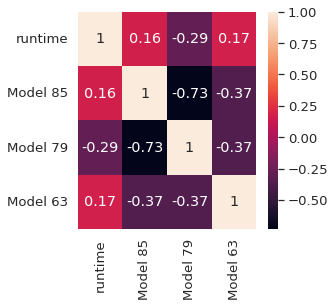

data 
                              runtime  cpuType_unknown - Model 85  \
runtime                     1.000000                    0.163843   
cpuType_unknown - Model 85  0.163843                    1.000000   
cpuType_unknown - Model 79 -0.287490                   -0.733131   
cpuType_unknown - Model 63  0.169246                   -0.365287   

                            cpuType_unknown - Model 79  \
runtime                                      -0.287490   
cpuType_unknown - Model 85                   -0.733131   
cpuType_unknown - Model 79                    1.000000   
cpuType_unknown - Model 63                   -0.365287   

                            cpuType_unknown - Model 63  
runtime                                       0.169246  
cpuType_unknown - Model 85                   -0.365287  
cpuType_unknown - Model 79                   -0.365287  
cpuType_unknown - Model 63                    1.000000  


In [21]:
df_ct = df[['driver_invocation', 'provider', 'runtime', 'cpuType']]
df_mean_per_ct = df_ct.groupby(['driver_invocation', 'provider', 'cpuType'], observed=True).mean().reset_index()

label_rewrite = {
    "runtime" : "runtime",
    "cpuType_Intel(R) Xeon(R) Processor @ 2.50GHz - Model 63": "Xeon @ 2.5GHz\n(Model 63)",
    "cpuType_Intel(R) Xeon(R) Processor @ 3.00GHz - Model 63" : "Xeon @ 3.0GHz\n(Model 63)",
    "cpuType_Intel(R) Xeon(R) CPU E5-2673 v3 @ 2.40GHz - Model 63" : "Xeon \nE5-2673 v3\n@2.40GHz (Model 63)",
    "cpuType_Intel(R) Xeon(R) CPU E5-2673 v4 @ 2.30GHz - Model 79" : "Xeon \nE5-2673 v4\n@2.30GHz (Model 79)",
    "cpuType_Intel(R) Xeon(R) Platinum 8171M CPU @ 2.60GHz - Model 85" : "Xeon Platinum 8171M\n@2.60GHz (Model 85)",
    "cpuType_Intel(R) Xeon(R) Platinum 8272CL CPU @ 2.60GHz - Model 85" : "Xeon Platinum 8272CL\n@2.60GHz (Model 85)",
    "cpuType_unknown - Model 63" : "Model 63",
    "cpuType_unknown - Model 79" : "Model 79",
    "cpuType_unknown - Model 85" : "Model 85",
}

for p in ['AWS', 'AZURE', 'GCP']:
        pdf = df_mean_per_ct[df_mean_per_ct['provider'] == p]
        cols = [ f"cpuType_{c}" for c in list(pdf['cpuType'].unique())]
        cols = ['runtime'] + cols
        dummydf = pd.get_dummies(pdf[['runtime', 'cpuType']], 'cpuType')[cols]
        fig, axes = plt.subplots(figsize=(4,4))
        
        heatmap = sns.heatmap(dummydf.corr(), annot=True)
        heatmap.set_xticklabels([label_rewrite[l.get_text()] for l in heatmap.get_xticklabels()]) 
        heatmap.set_yticklabels([label_rewrite[l.get_text()] for l in heatmap.get_yticklabels()])
        utils.plot(['provider_analysis_instances', f'pa_instance_cpus_types_runtime_invocation_{p}'], data=dummydf.corr())

In [8]:
def process_linux_version(row):    
    if (row['provider'] == 'AWS'):
        val = row['linuxVersion']
        xpos = val.find(" ", 6)
        val = val[xpos+1:]
        row['linuxVersion'] = val
    elif (row['provider'] == 'AZURE'):
        val = row['linuxVersion']
        xpos = val.find(" ", 6)
        val = val[xpos+1:]
        row['linuxVersion'] = val
    elif (row['provider'] == 'GCP'):
        pass
    else:
        raise Exception("Error Processing Linux Version")
    return row

import swifter
df_linux = df[['workload_invocation','provider', 'linuxVersion']].swifter.apply(process_linux_version, axis=1)

Dask Apply:   0%|          | 0/40 [00:00<?, ?it/s]

In [9]:
# Count different version on workload invocations.
df_linux.groupby(['provider', 'linuxVersion']).nunique()

workload_invocation
provider linuxVersion                                                           
AWS      4.14.231-180.360.amzn2.x86_64 #1 SMP Mon Apr 19...                11589
         4.14.243-194.434.amzn2.x86_64 #1 SMP Tue Aug 17...                17573
AZURE    5.4.81-microsoft-standard #1 SMP Thu Dec 3 23:4...                25963
GCP      Linux localhost 4.4.0 #1 SMP Sun Jan 10 15:06:5...                28919